## Imports

In [1]:
import time
import os
import cv2
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision import datasets

os.environ['KMP_DUPLICATE_LIB_OK']='True'

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    

In [2]:
%matplotlib inline

In [3]:
# Device and parameters setting
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 3
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 2

cpu


In [4]:
#dataset setting
import os

num_train_cats = len([i for i in os.listdir(os.path.join('D:/catsandogs/train'))
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join('D:/catsandogs/train'))
                      if i.endswith('.jpg') and i.startswith('dog')])

print(f'Training set cats: {num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

Training set cats: 10000
Training set dogs: 10000


(331, 464, 3)


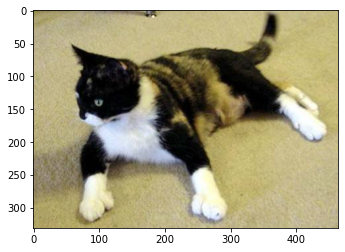

In [5]:
img = Image.open(os.path.join('D:/catsandogs/train/cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img)

In [6]:
if not os.path.exists(os.path.join('D:/catsandogs/test')):
    os.mkdir(os.path.join('D:/catsandogs/test'))

if not os.path.exists(os.path.join('D:/catsandogs/valid')):
    os.mkdir(os.path.join('D:/catsandogs/valid'))

In [7]:
for fname in os.listdir(os.path.join('D:/catsandogs/train')):
    if not fname.endswith('.jpg'):
        continue
    _, img_num, _ = fname.split('.')
    filepath = os.path.join('D:/catsandogs/train', fname)
    img_num = int(img_num)
    if img_num > 11249:
        os.rename(filepath, filepath.replace('D:/catsandogs/train', 'D:/catsandogs/test'))
    elif img_num > 9999:
        os.rename(filepath, filepath.replace('D:/catsandogs/train', 'D:/catsandogs/valid'))

### Standardizing Images

In [8]:
class CatsDogsDataset():

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'cat':
                self.y.append(0)
            else:
                self.y.append(1)
        
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)    

In [9]:
imsize = 512 if torch.cuda.is_available() else 128
custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),
                                        transforms.ToTensor()])

train_dataset = CatsDogsDataset(img_dir=os.path.join('D:/catsandogs/train'),
                                transform=custom_transform1)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=5000, 
                          shuffle=True)
print(train_loader)

In [10]:
train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)


train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))


print('Mean:',train_mean)
print('Std Dev:',train_std)


Mean: tensor([0.4875, 0.4544, 0.4164])
Std Dev: tensor([0.2521, 0.2453, 0.2481])


### Dataloaders

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_dataset = CatsDogsDataset(img_dir=os.path.join('D:/catsandogs/train'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = CatsDogsDataset(img_dir=os.path.join('D:/catsandogs/valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_dataset = CatsDogsDataset(img_dir=os.path.join('D:/catsandogs/test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

## Model

In [25]:


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*2*2, 4096),
                nn.ReLU(),   
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
            
        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*2*2))
        probas = F.softmax(logits, dim=1)

        return logits, probas

In [26]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)

model = model.to(DEVICE)



optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [14]:

def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    


    
    
start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/003 | Batch 000/156 | Cost: 1008.3969
Epoch: 001/003 | Batch 120/156 | Cost: 0.7174
Epoch: 001/003 Train Acc.: 63.92% | Validation Acc.: 62.28%
Time elapsed: 44.93 min
Epoch: 002/003 | Batch 000/156 | Cost: 0.6253
Epoch: 002/003 | Batch 120/156 | Cost: 0.6528
Epoch: 002/003 Train Acc.: 62.11% | Validation Acc.: 62.64%
Time elapsed: 87.69 min
Epoch: 003/003 | Batch 000/156 | Cost: 0.6817
Epoch: 003/003 | Batch 120/156 | Cost: 0.6189
Epoch: 003/003 Train Acc.: 61.49% | Validation Acc.: 60.40%
Time elapsed: 121.94 min
Total Training Time: 121.94 min


## Evaluation

In [15]:
model.eval()
with torch.set_grad_enabled(False):
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 59.80%


In [16]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.

        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    

unorm = UnNormalize(mean=train_mean, std=train_std)

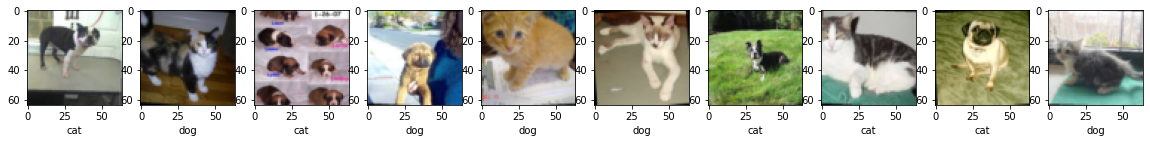

In [27]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:10].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'cat',
     1: 'dog'}
    
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

In [18]:
from itertools import product
from sklearn.metrics import plot_confusion_matrix
class_dict={0: 'Cat', 1: 'Dog'}

In [19]:
def computeconfusionmatrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(probas, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [20]:
def plotconfusionmatrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                num = conf_mat[i, j].astype(np.int64) 
                cell_text += format(num, 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model

In [22]:
model = VGG16(NUM_CLASSES)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<function matplotlib.pyplot.show(close=None, block=None)>

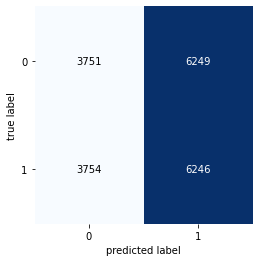

In [28]:
mat=computeconfusionmatrix(model,test_loader,DEVICE)
matrix=plotconfusionmatrix(mat,class_dict.values())
plt.show

In [29]:
tn=mat[0][0]
tp=mat[1][1]
fp=mat[0][1]
fn=mat[1][0]

acc=np.sum(np.diag(mat)/np.sum(mat))
sensitivity=tp/(tp+fn)
precision=tp/(tp+fp)

print('- Sensitivity : ',(tp/(tp+fn))*100)
print('- Specificity : ',(tn/(tn+fp))*100)
print('- Precision: ',(tp/(tp+fp))*100)



- Sensitivity :  62.46000000000001
- Specificity :  37.51
- Precision:  49.98799519807923


Text(0, 0.5, 'Specificity')

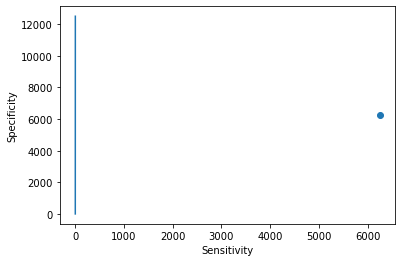

In [65]:
plt.scatter(tp, fp)
plt.plot([0 ,12500])
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')